# Catch22 Features
all nine conditions

In [ ]:
!pip install pycatch22

In [ ]:
import numpy as np
import pickle
import pandas as pd
from pycatch22 import catch22_all
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# === Load data ===

file_path = "/content/drive/MyDrive/Thesis/compiled_pupil_6D_array.pkl"
with open(file_path, "rb") as f:
    pupil_data = pickle.load(f)  # shape: (subjects, conditions, epochs, time, channels, eyes)

In [ ]:
data = pupil_data['data']

print(data.shape)

(64, 9, 55, 3481, 1, 2)


In [ ]:
print("⚙️ Extracting features using catch22...")
features_list = []
labels_condition = []
labels_subcondition = []  # optional, if you want to split conditions further
feature_names = []  # Initialize as an empty list

# === Mapping conditions to label values (customize as needed) ===
# For example: 0 = just listen, 1 = 5 items, 2 = 9 items, 3 = 13 items
# You can treat them as binary (just listen = 0, others = 1) or multiclass
for subj_idx, subj in enumerate(data):
    for cond_idx, condition in enumerate(subj):
        for epoch in condition:
            feature_vector = []

            for ch in range(epoch.shape[1]):  # over channels
                for eye in range(epoch.shape[2]):  # over eyes
                    signal = epoch[:, ch, eye]
                    signal = signal[~np.isnan(signal)]  # NaN-safe

                    if len(signal) < 10:  # skip too-short signals
                        features = [np.nan] * 22
                    else:
                        res = catch22_all(signal)
                        features = res["values"]
                        # Generate feature names for the current channel and eye
                        current_feature_names = [f"{name}_ch{ch}_eye{eye}" for name in res["names"]]

                        # Append feature names if not already in the list
                        for name in current_feature_names:
                            if name not in feature_names:
                                feature_names.append(name)

                    feature_vector.extend(features)

            features_list.append(feature_vector)
            labels_condition.append(cond_idx)
            labels_subcondition.append(f"subj{subj_idx}_cond{cond_idx}")


# === Construct DataFrame ===
features_df = pd.DataFrame(features_list, columns=feature_names)
print(f"✅ Extracted features: {features_df.shape[1]} columns, {features_df.shape[0]} samples")

⚙️ Extracting features using catch22...
✅ Extracted features: 44 columns, 31680 samples


In [ ]:
# === Save to pickle ===
features_output_path = "/content/drive/MyDrive/Thesis/extracted_features_catch22.pkl"
with open(features_output_path, "wb") as f:
    pickle.dump({
        "features_array": features_df.values,
        "features_columns": features_df.columns.tolist(),
        "labels_condition": labels_condition,
        "labels_subcondition": labels_subcondition,
    }, f)

print("📦 Feature extraction complete. Data saved to:", features_output_path)

📦 Feature extraction complete. Data saved to: /content/drive/MyDrive/Thesis/extracted_features_catch22.pkl


In [ ]:
print(features_df.shape)

(31680, 44)


In [ ]:
print(feature_names)

['DN_HistogramMode_5_ch0_eye0', 'DN_HistogramMode_10_ch0_eye0', 'CO_f1ecac_ch0_eye0', 'CO_FirstMin_ac_ch0_eye0', 'CO_HistogramAMI_even_2_5_ch0_eye0', 'CO_trev_1_num_ch0_eye0', 'MD_hrv_classic_pnn40_ch0_eye0', 'SB_BinaryStats_mean_longstretch1_ch0_eye0', 'SB_TransitionMatrix_3ac_sumdiagcov_ch0_eye0', 'PD_PeriodicityWang_th0_01_ch0_eye0', 'CO_Embed2_Dist_tau_d_expfit_meandiff_ch0_eye0', 'IN_AutoMutualInfoStats_40_gaussian_fmmi_ch0_eye0', 'FC_LocalSimple_mean1_tauresrat_ch0_eye0', 'DN_OutlierInclude_p_001_mdrmd_ch0_eye0', 'DN_OutlierInclude_n_001_mdrmd_ch0_eye0', 'SP_Summaries_welch_rect_area_5_1_ch0_eye0', 'SB_BinaryStats_diff_longstretch0_ch0_eye0', 'SB_MotifThree_quantile_hh_ch0_eye0', 'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1_ch0_eye0', 'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1_ch0_eye0', 'SP_Summaries_welch_rect_centroid_ch0_eye0', 'FC_LocalSimple_mean3_stderr_ch0_eye0', 'DN_HistogramMode_5_ch0_eye1', 'DN_HistogramMode_10_ch0_eye1', 'CO_f1ecac_ch0_eye1', 'CO_FirstMin_ac_ch0_eye1', '

Catch22 features based classification

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
# === Load extracted features ===
with open("extracted_features_catch22.pkl", "rb") as f:
    data = pickle.load(f)

In [ ]:
X = data["features_array"]
y_multiclass = np.array(data["labels_condition"])  # 0 = just listen, 1 = 5, 2 = 9, 3 = 13
y_binary = np.where(y_multiclass == 0, 0, 1)        # 0 = just listen, 1 = engaged

print(f" Loaded features: {X.shape}, Labels: {len(y_multiclass)}")

 Loaded features: (31680, 44), Labels: 31680


In [ ]:
print("🔍 Original labels_condition unique values:", np.unique(y_multiclass))

🔍 Original labels_condition unique values: [0 1 2 3 4 5 6 7 8]


In [ ]:

# === Handle missing values ===
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# === Normalize ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [ ]:
# === Split data ===
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_scaled, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass)


🌳 Random Forest - Binary Classification:
📊 Classification Report (Binary):
              precision    recall  f1-score   support

           0       0.00      0.01      0.00       704
           1       0.87      0.81      0.84      5632

    accuracy                           0.72      6336
   macro avg       0.44      0.41      0.42      6336
weighted avg       0.77      0.72      0.75      6336

🎯 Accuracy (Binary): 0.7223800505050505


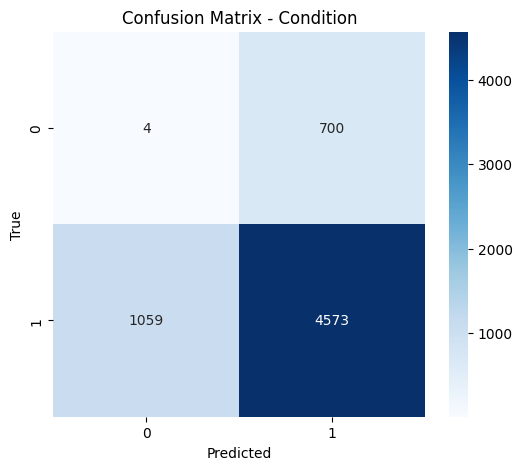

In [ ]:
# === Random Forest for Binary Classification ===
print("\n🌳 Random Forest - Binary Classification:")
rf_bin = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_bin.fit(X_train_bin, y_train_bin)
y_pred_bin = rf_bin.predict(X_test_bin)

print("📊 Classification Report (Binary):")
print(classification_report(y_test_bin, y_pred_bin))
print("🎯 Accuracy (Binary):", accuracy_score(y_test_bin, y_pred_bin))

# ✅ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_bin, y_pred_bin), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Condition")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


🌳 Random Forest - Multiclass Classification:
📊 Classification Report (Multiclass):
              precision    recall  f1-score   support

           0       0.01      0.01      0.01       704
           1       0.01      0.01      0.01       704
           2       0.01      0.01      0.01       704
           3       0.01      0.01      0.01       704
           4       0.01      0.01      0.01       704
           5       0.00      0.00      0.00       704
           6       0.01      0.01      0.01       704
           7       0.01      0.01      0.01       704
           8       0.09      0.17      0.11       704

    accuracy                           0.03      6336
   macro avg       0.02      0.03      0.02      6336
weighted avg       0.02      0.03      0.02      6336

🎯 Accuracy (Multiclass): 0.02556818181818182


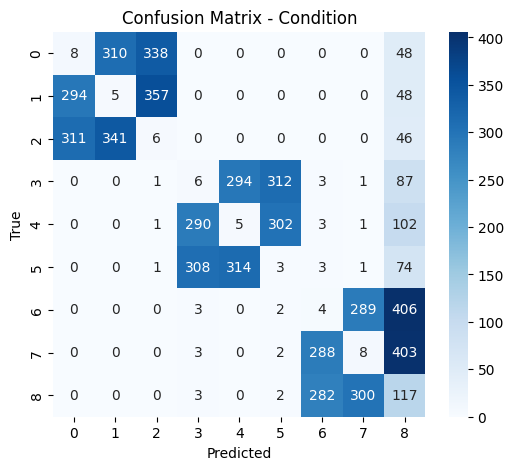

In [ ]:
# === Random Forest for Multiclass Classification ===
print("\n🌳 Random Forest - Multiclass Classification:")
rf_multi = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_multi.fit(X_train_multi, y_train_multi)
y_pred_multi = rf_multi.predict(X_test_multi)

print("📊 Classification Report (Multiclass):")
print(classification_report(y_test_multi, y_pred_multi))
print("🎯 Accuracy (Multiclass):", accuracy_score(y_test_multi, y_pred_multi))

# ✅ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_multi, y_pred_multi), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Condition")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

<ipython-input-21-73b5be58682d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")
<ipython-input-21-73b5be58682d>:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


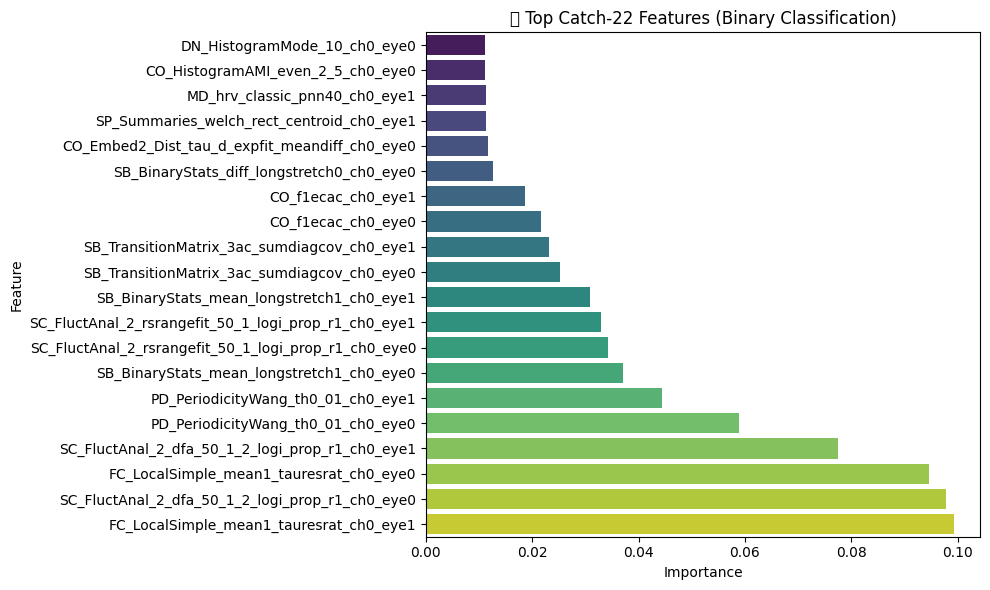

<ipython-input-21-73b5be58682d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")
<ipython-input-21-73b5be58682d>:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


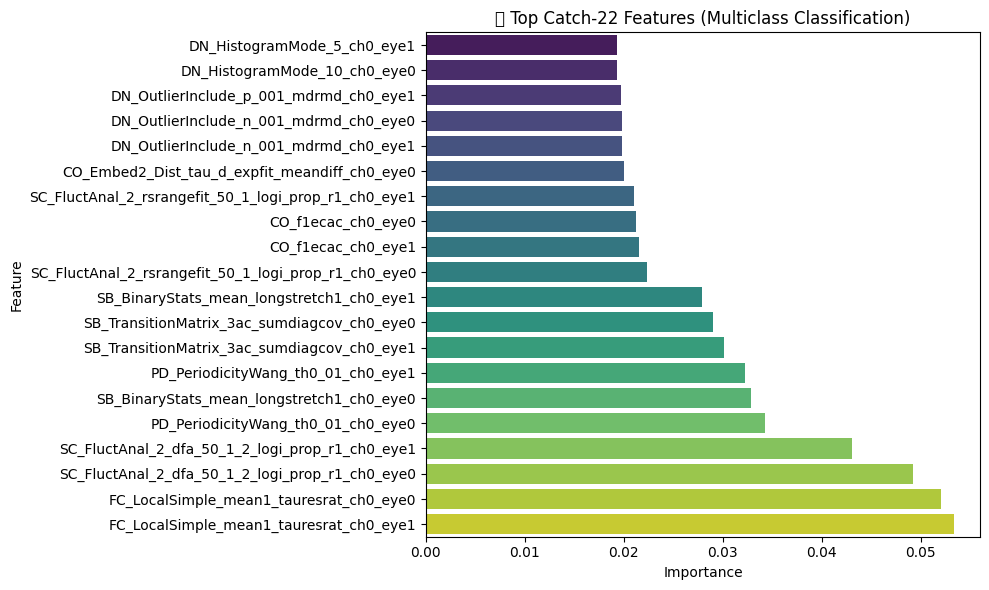

In [ ]:
# === Plotting Feature Importances ===
def plot_feature_importance(importances, title, feature_names, top_n=20):
    sorted_idx = np.argsort(importances)[-top_n:]
    top_features = [feature_names[i] for i in sorted_idx]
    top_importances = importances[sorted_idx]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_importances, y=top_features, palette="viridis")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# === Binary Feature Importance ===
plot_feature_importance(
    rf_bin.feature_importances_,
    "🔍 Top Catch-22 Features (Binary Classification)",
    feature_names
)

# === Multiclass Feature Importance ===
plot_feature_importance(
    rf_multi.feature_importances_,
    "🔍 Top Catch-22 Features (Multiclass Classification)",
    feature_names
)

# Catch22 Features
subconditions classification

In [ ]:
import pickle
import numpy as np
import pandas as pd

# === Load your data ===
file_path = "/content/drive/MyDrive/Thesis/compiled_pupil_6D_array.pkl"

with open(file_path, "rb") as f:
    data = pickle.load(f)

# The 'epochs' data seems to be stored under the 'data' key itself:
epochs_data = data["data"]

# Create a mapping from condition names to event codes
conditions = data["conditions"]
# Example event code mapping (Adapt to your specific event codes and conditions):
condition_to_event_code = {
    'justlisten/five': 500105,
    'memory/correct/five': 6001051,
    'memory/incorrect/five': 6001050,
    'justlisten/nine': 500109,
    'memory/correct/nine': 6001091,
    'memory/incorrect/nine': 6001090,
    'justlisten/thirteen': 500113,
    'memory/correct/thirteen': 6001131,
    'memory/incorrect/thirteen': 6001130,
}

# Function to retrieve event code based on condition index
def get_event_code(condition_index):
    condition_name = conditions[condition_index]
    return condition_to_event_code.get(condition_name)

# === Event code to label mapping ===
event_code_map = {
    500105: (0, 0),  # justlisten/five
    6001051: (1, 1),  # memory/correct/five
    6001050: (1, 1),  # memory/incorrect/five
    500109: (0, 0),
    6001091: (1, 2),
    6001090: (1, 2),
    500113: (0, 0),
    6001131: (1, 3),
    6001130: (1, 3),
}

In [ ]:
# === Feature Extraction ===
features_list = []
binary_labels = []
multiclass_labels = []

print("⚙️ Extracting features using catch22...")

for subj_idx, subj in enumerate(epochs_data):
    for cond_idx, condition in enumerate(subj):
        condition_name = conditions[cond_idx]
        event_code = condition_to_event_code.get(condition_name)

        if event_code not in event_code_map:
            continue

        for ep_idx, epoch in enumerate(condition):
            feature_vector = []
            for ch in range(epoch.shape[1]):
                for eye in range(epoch.shape[2]):
                    signal = epoch[:, ch, eye]
                    signal = signal[~np.isnan(signal)]
                    if len(signal) < 10:
                        features = [np.nan] * 22
                    else:
                        features = catch22_all(signal)["values"]
                    feature_vector.extend(features)

            features_list.append(feature_vector)
            binary_labels.append(event_code_map[event_code][0])
            multiclass_labels.append(event_code_map[event_code][1])

X = np.array(features_list)
y_binary = np.array(binary_labels)
y_multi = np.array(multiclass_labels)

print("✅ Feature extraction complete.")
print("X shape:", X.shape)
print("Binary label distribution:", np.bincount(y_binary))
print("Multiclass label distribution:", np.bincount(y_multi))


⚙️ Extracting features using catch22...
✅ Feature extraction complete.
X shape: (31680, 44)
Binary label distribution: [10560 21120]
Multiclass label distribution: [10560  7040  7040  7040]


In [ ]:
# Assuming X, y_binary, and y_multi are your processed NumPy arrays

save_path = "/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl"

data_to_save = {
    'features': X,
    'binary_labels': y_binary,
    'multiclass_labels': y_multi
}

with open(save_path, 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"💾 Processed data saved to: {save_path}")

💾 Processed data saved to: /content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl


In [ ]:
import pickle
import numpy as np

# Define the path to your saved pickle file
load_path = "/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl"

try:
    with open(load_path, 'rb') as f:
        loaded_data = pickle.load(f)

    X_loaded = loaded_data['features']
    y_binary_loaded = loaded_data['binary_labels']
    y_multi_loaded = loaded_data['multiclass_labels']

    print("✅ Loaded processed data successfully!")
    print("Loaded X shape:", X_loaded.shape)
    print("Loaded Binary label distribution:", np.bincount(y_binary_loaded))
    print("Loaded Multiclass label distribution:", np.bincount(y_multi_loaded))

except FileNotFoundError:
    print(f"❌ Error: File not found at {load_path}")
except Exception as e:
    print(f"❌ An error occurred during loading: {e}")

✅ Loaded processed data successfully!
Loaded X shape: (31680, 44)
Loaded Binary label distribution: [10560 21120]
Loaded Multiclass label distribution: [10560  7040  7040  7040]


In [ ]:
print("Unique values in y_multiclass:", np.unique(y_multi))
print("Unique values in y_multiclass:", np.unique(y_binary))

Unique values in y_multiclass: [0 1 2 3]
Unique values in y_multiclass: [0 1]


## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# === Load extracted features ===
load_path = "/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl"

with open(load_path, 'rb') as f:
  loaded_data = pickle.load(f)

In [ ]:
X_loaded = loaded_data['features']
y_binary_loaded = loaded_data['binary_labels']
y_multi_loaded = loaded_data['multiclass_labels']

print(f" Loaded features: {X.shape}, Labels: {len(y_multi_loaded)}")

 Loaded features: (31680, 44), Labels: 31680


In [ ]:
print("✅ Loaded processed data successfully!")
print("Loaded X shape:", X_loaded.shape)
print("Loaded Binary label distribution:", np.bincount(y_binary_loaded))
print("Loaded Multiclass label distribution:", np.bincount(y_multi_loaded))


✅ Loaded processed data successfully!
Loaded X shape: (31680, 44)
Loaded Binary label distribution: [10560 21120]
Loaded Multiclass label distribution: [10560  7040  7040  7040]


🔍 Binary Classification Report:

              precision    recall  f1-score   support

           0       0.07      0.11      0.08      2112
           1       0.35      0.24      0.28      4224

    accuracy                           0.19      6336
   macro avg       0.21      0.17      0.18      6336
weighted avg       0.25      0.19      0.22      6336

🎯 Accuracy (Binary): 0.19428661616161616


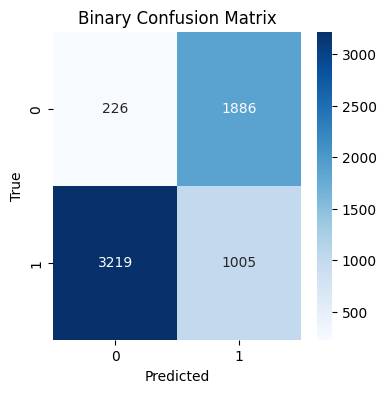

In [ ]:
# Split data for binary classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_loaded, y_binary_loaded, test_size=0.2, random_state=42, stratify=y_binary)

# Train Random Forest for binary classification
rf_bin = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_bin.fit(X_train_bin, y_train_bin)

# Predict & Evaluate
y_pred_bin = rf_bin.predict(X_test_bin)

print("🔍 Binary Classification Report:\n")
print(classification_report(y_test_bin, y_pred_bin))
print("🎯 Accuracy (Binary):", accuracy_score(y_test_bin, y_pred_bin))

# Confusion matrix (binary)
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test_bin, y_pred_bin), annot=True, fmt='d', cmap='Blues')
plt.title("Binary Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

🔍 Multiclass Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2112
           1       0.61      0.74      0.67      1408
           2       0.59      0.65      0.62      1408
           3       0.50      0.79      0.61      1408

    accuracy                           0.49      6336
   macro avg       0.43      0.55      0.48      6336
weighted avg       0.38      0.49      0.42      6336

🎯 Accuracy (Binary): 0.4864267676767677


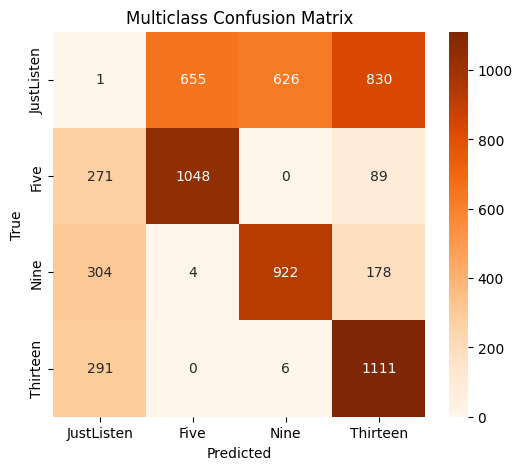

In [ ]:
# Split data for multiclass classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_loaded, y_multi_loaded, test_size=0.2, random_state=42, stratify=y_multi
)

# Train Random Forest for multiclass classification
rf_multi = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_multi.fit(X_train_multi, y_train_multi)

# Predict & Evaluate
y_pred_multi = rf_multi.predict(X_test_multi)
print("🔍 Multiclass Classification Report:\n")
print(classification_report(y_test_multi, y_pred_multi))
print("🎯 Accuracy (Binary):", accuracy_score(y_test_multi, y_pred_multi))

# Confusion matrix (multiclass)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_multi, y_pred_multi), annot=True, fmt='d', cmap='Oranges',
            xticklabels=["JustListen", "Five", "Nine", "Thirteen"],
            yticklabels=["JustListen", "Five", "Nine", "Thirteen"])
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## CNN

In [ ]:
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# === Load extracted features ===
load_path = "/content/drive/MyDrive/Thesis/subcondition_catch22_features.pkl"

with open(load_path, 'rb') as f:
  loaded_data = pickle.load(f)

In [ ]:
X_loaded = loaded_data['features']
y_binary_loaded = loaded_data['binary_labels']
y_multi_loaded = loaded_data['multiclass_labels']

print(f" Loaded features: {X.shape}, Labels: {len(y_multi_loaded)}")

 Loaded features: (31680, 44), Labels: 31680


In [ ]:
# ===  Binary ===
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split # import train_test_split
from sklearn.impute import SimpleImputer


# === Prepare Data (with SMOTE) ===
n_samples, n_features = X_loaded.shape
image_shape = (11, 4)  # adjust as per X.shape[1]
assert np.prod(image_shape) == n_features, "Reshape dimensions must match feature size"

X_reshaped = X_loaded.reshape((n_samples, *image_shape, 1))
X_reshaped_2d = X_reshaped.reshape(n_samples, -1)

# Impute NaN values using SimpleImputer before applying SMOTE
imputer = SimpleImputer(strategy='mean')  # or other strategies like 'median', 'most_frequent'
X_reshaped_2d = imputer.fit_transform(X_reshaped_2d)

# Perform the train-test split before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_reshaped_2d, y_binary_loaded, test_size=0.2, random_state=42, stratify=y_binary_loaded)


# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled training class distribution:", Counter(y_train_resampled))

# Reshape back to the original image shape if necessary for your model
X_train_resampled = X_train_resampled.reshape(-1, *image_shape, 1)
X_test = X_test.reshape(-1, *image_shape, 1) # Reshape X_test as well

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).permute(0, 3, 1, 2)  # Change shape to (samples, channels, height, width)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Resampled training class distribution: Counter({np.int64(0): 16896, np.int64(1): 16896})


In [ ]:
# === CNN Model Binary ===
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 2 * 1, 64)  # Adjusted for image shape (64 channels, 2x1 spatial size)
        self.fc2 = nn.Linear(64, 2)  # 2 classes for binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply first conv + pool
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))  # Apply second conv + pool
        x = self.dropout(x)
        x = x.view(-1, 64 * 2 * 1)  # Flatten the output from (64, 2, 1) to (batch_size, 128)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, num_classes=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')  # We will manually apply reduction

    def forward(self, inputs, targets):
        # Apply CrossEntropy loss
        ce_loss = self.ce_loss(inputs, targets)

        # Calculate p_t (probability for true class)
        pt = torch.exp(-ce_loss)  # p_t = e^(-CE Loss)

        # Focal loss formula
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
# Instantiate Focal Loss with desired alpha and gamma values
criterion = FocalLoss(alpha=0.25, gamma=2.0)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Instantiate model, optimizer, etc.
from torch.optim import SGD
model = CNNModel()
optimizer = SGD(model.parameters(), lr=0.001)


In [ ]:
# === Train Model ===
epochs = 20
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Use the Focal Loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation accuracy
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/20, Loss: 0.0459, Train Accuracy: 0.5003, Val Accuracy: 0.3333
Epoch 2/20, Loss: 0.0434, Train Accuracy: 0.4970, Val Accuracy: 0.6667
Epoch 3/20, Loss: 0.0434, Train Accuracy: 0.4940, Val Accuracy: 0.3333
Epoch 4/20, Loss: 0.0433, Train Accuracy: 0.5001, Val Accuracy: 0.3333
Epoch 5/20, Loss: 0.0433, Train Accuracy: 0.5031, Val Accuracy: 0.6667
Epoch 6/20, Loss: 0.0434, Train Accuracy: 0.4981, Val Accuracy: 0.6667
Epoch 7/20, Loss: 0.0434, Train Accuracy: 0.4997, Val Accuracy: 0.3333
Epoch 8/20, Loss: 0.0433, Train Accuracy: 0.4999, Val Accuracy: 0.6667
Epoch 9/20, Loss: 0.0434, Train Accuracy: 0.4967, Val Accuracy: 0.3333
Epoch 10/20, Loss: 0.0433, Train Accuracy: 0.5006, Val Accuracy: 0.6667
Epoch 11/20, Loss: 0.0433, Train Accuracy: 0.4975, Val Accuracy: 0.3333
Epoch 12/20, Loss: 0.0433, Train Accuracy: 0.4955, Val Accuracy: 0.6667
Epoch 13/20, Loss: 0.0434, Train Accuracy: 0.4970, Val Accuracy: 0.6667
Epoch 14/20, Loss: 0.0433, Train Accuracy: 0.4976, Val Accuracy: 0.3333
E

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# === Evaluate ===
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

print("📋 CNN Classification Report:\n")
print(classification_report(y_true, y_pred))
print("🎯 Accuracy (CNN):", accuracy_score(y_true, y_pred))

# Confusion matrix (binary)
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Binary Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

NameError: name 'model' is not defined

In [ ]:
print("Training class distribution:", np.bincount(y_train))
print("Class weights:", class_weights_tensor)

Training class distribution: [ 8448 16896]
Class weights: tensor([1.5000, 0.7500])


In [ ]:
# ===  Multiclass ===

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split # import train_test_split
from sklearn.impute import SimpleImputer


# === Prepare Data (with SMOTE) ===
n_samples, n_features = X_loaded.shape
image_shape = (11, 4)  # adjust as per X.shape[1]
assert np.prod(image_shape) == n_features, "Reshape dimensions must match feature size"

X_reshaped = X_loaded.reshape((n_samples, *image_shape, 1))
X_reshaped_2d = X_reshaped.reshape(n_samples, -1)

# Impute NaN values using SimpleImputer before applying SMOTE
imputer = SimpleImputer(strategy='mean')  # or other strategies like 'median', 'most_frequent'
X_reshaped_2d = imputer.fit_transform(X_reshaped_2d)

# Perform the train-test split before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_reshaped_2d, y_multi_loaded, test_size=0.2, random_state=42, stratify=y_multi_loaded)


# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled training class distribution:", Counter(y_train_resampled))

# Reshape back to the original image shape if necessary for your model
X_train_resampled = X_train_resampled.reshape(-1, *image_shape, 1)
X_test = X_test.reshape(-1, *image_shape, 1) # Reshape X_test as well

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).permute(0, 3, 1, 2)  # Change shape to (samples, channels, height, width)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Resampled training class distribution: Counter({np.int64(2): 8448, np.int64(3): 8448, np.int64(1): 8448, np.int64(0): 8448})


In [ ]:
# === Define CNN Model ===
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)

        flattened_size = (image_shape[0] // 4) * (image_shape[1] // 4) * 64
        self.fc1 = nn.Linear(flattened_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # (B, 32, H/2, W/2)
        x = self.pool2(F.relu(self.conv2(x)))  # (B, 64, H/4, W/4)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# === Train the model ===
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier(num_classes=4).to(device)


criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/20, Loss: 1553.1546
Epoch 2/20, Loss: 1429.0096
Epoch 3/20, Loss: 1409.0516
Epoch 4/20, Loss: 1397.2881
Epoch 5/20, Loss: 1381.5860
Epoch 6/20, Loss: 1372.3566
Epoch 7/20, Loss: 1368.7859
Epoch 8/20, Loss: 1357.3427
Epoch 9/20, Loss: 1353.3233
Epoch 10/20, Loss: 1348.7406
Epoch 11/20, Loss: 1344.4209
Epoch 12/20, Loss: 1338.1122
Epoch 13/20, Loss: 1337.3683
Epoch 14/20, Loss: 1335.6004
Epoch 15/20, Loss: 1328.9575
Epoch 16/20, Loss: 1323.6624
Epoch 17/20, Loss: 1319.2171
Epoch 18/20, Loss: 1316.8747
Epoch 19/20, Loss: 1314.4236
Epoch 20/20, Loss: 1311.1329



📊 Multi-class Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.03      0.05      2112
           1       0.30      0.97      0.45      1408
           2       0.27      0.25      0.26      1408
           3       0.56      0.11      0.18      1408

    accuracy                           0.30      6336
   macro avg       0.38      0.34      0.24      6336
weighted avg       0.38      0.30      0.21      6336

🎯 Accuracy: 0.30303030303030304


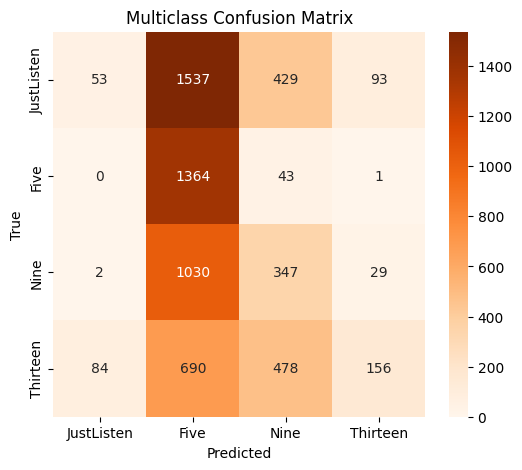

In [ ]:
# === Evaluate ===
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(labels.numpy())

# Report
print("\n📊 Multi-class Classification Report:")
print(classification_report(all_true, all_preds))
print("🎯 Accuracy:", accuracy_score(all_true, all_preds))

# Confusion matrix (multiclass)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(all_true, all_preds), annot=True, fmt='d', cmap='Oranges',
            xticklabels=["JustListen", "Five", "Nine", "Thirteen"],
            yticklabels=["JustListen", "Five", "Nine", "Thirteen"])
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()